# Decision Tree, KNN, NB, SVM Homework


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline



In [2]:
# DON'T CHANGE ANYTHING HERE....
random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )
    
    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000
    
    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]
    
    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6
    
    remove_values(df, df.columns, perc=0.05)
    
    return df, pd.Series(y)
    
X, y = create_df()

In [3]:
# eda code
print(X.head())
print(X.info())
print(X.describe())

         f1         f2           f3        f4        f5 f6
0  3.083178   3.022878  1276.390696 -2.672085  1.085629  B
1       NaN   1.764094  -873.709051  2.084035  0.387268  A
2  8.663599        NaN  -563.461158 -0.044922  2.512673  A
3       NaN   3.899908   753.129656  1.565944 -3.771516  A
4  0.684772  22.623978  -392.739840 -0.136113 -2.028027  A
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f1      949933 non-null  float64
 1   f2      949884 non-null  float64
 2   f3      949804 non-null  float64
 3   f4      950444 non-null  float64
 4   f5      950149 non-null  float64
 5   f6      949983 non-null  object 
dtypes: float64(5), object(1)
memory usage: 45.8+ MB
None
                 f1            f2             f3             f4             f5
count  9.499330e+05  9.498840e+05  949804.000000  950444.000000  950149.000000
mean   2.970269

/var/folders/7c/z12nzz6s19zbls8hvs28v8tw0000gn/T/ipykernel_1548/2187134813.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, ax=axs[0, 0], palette="magma")


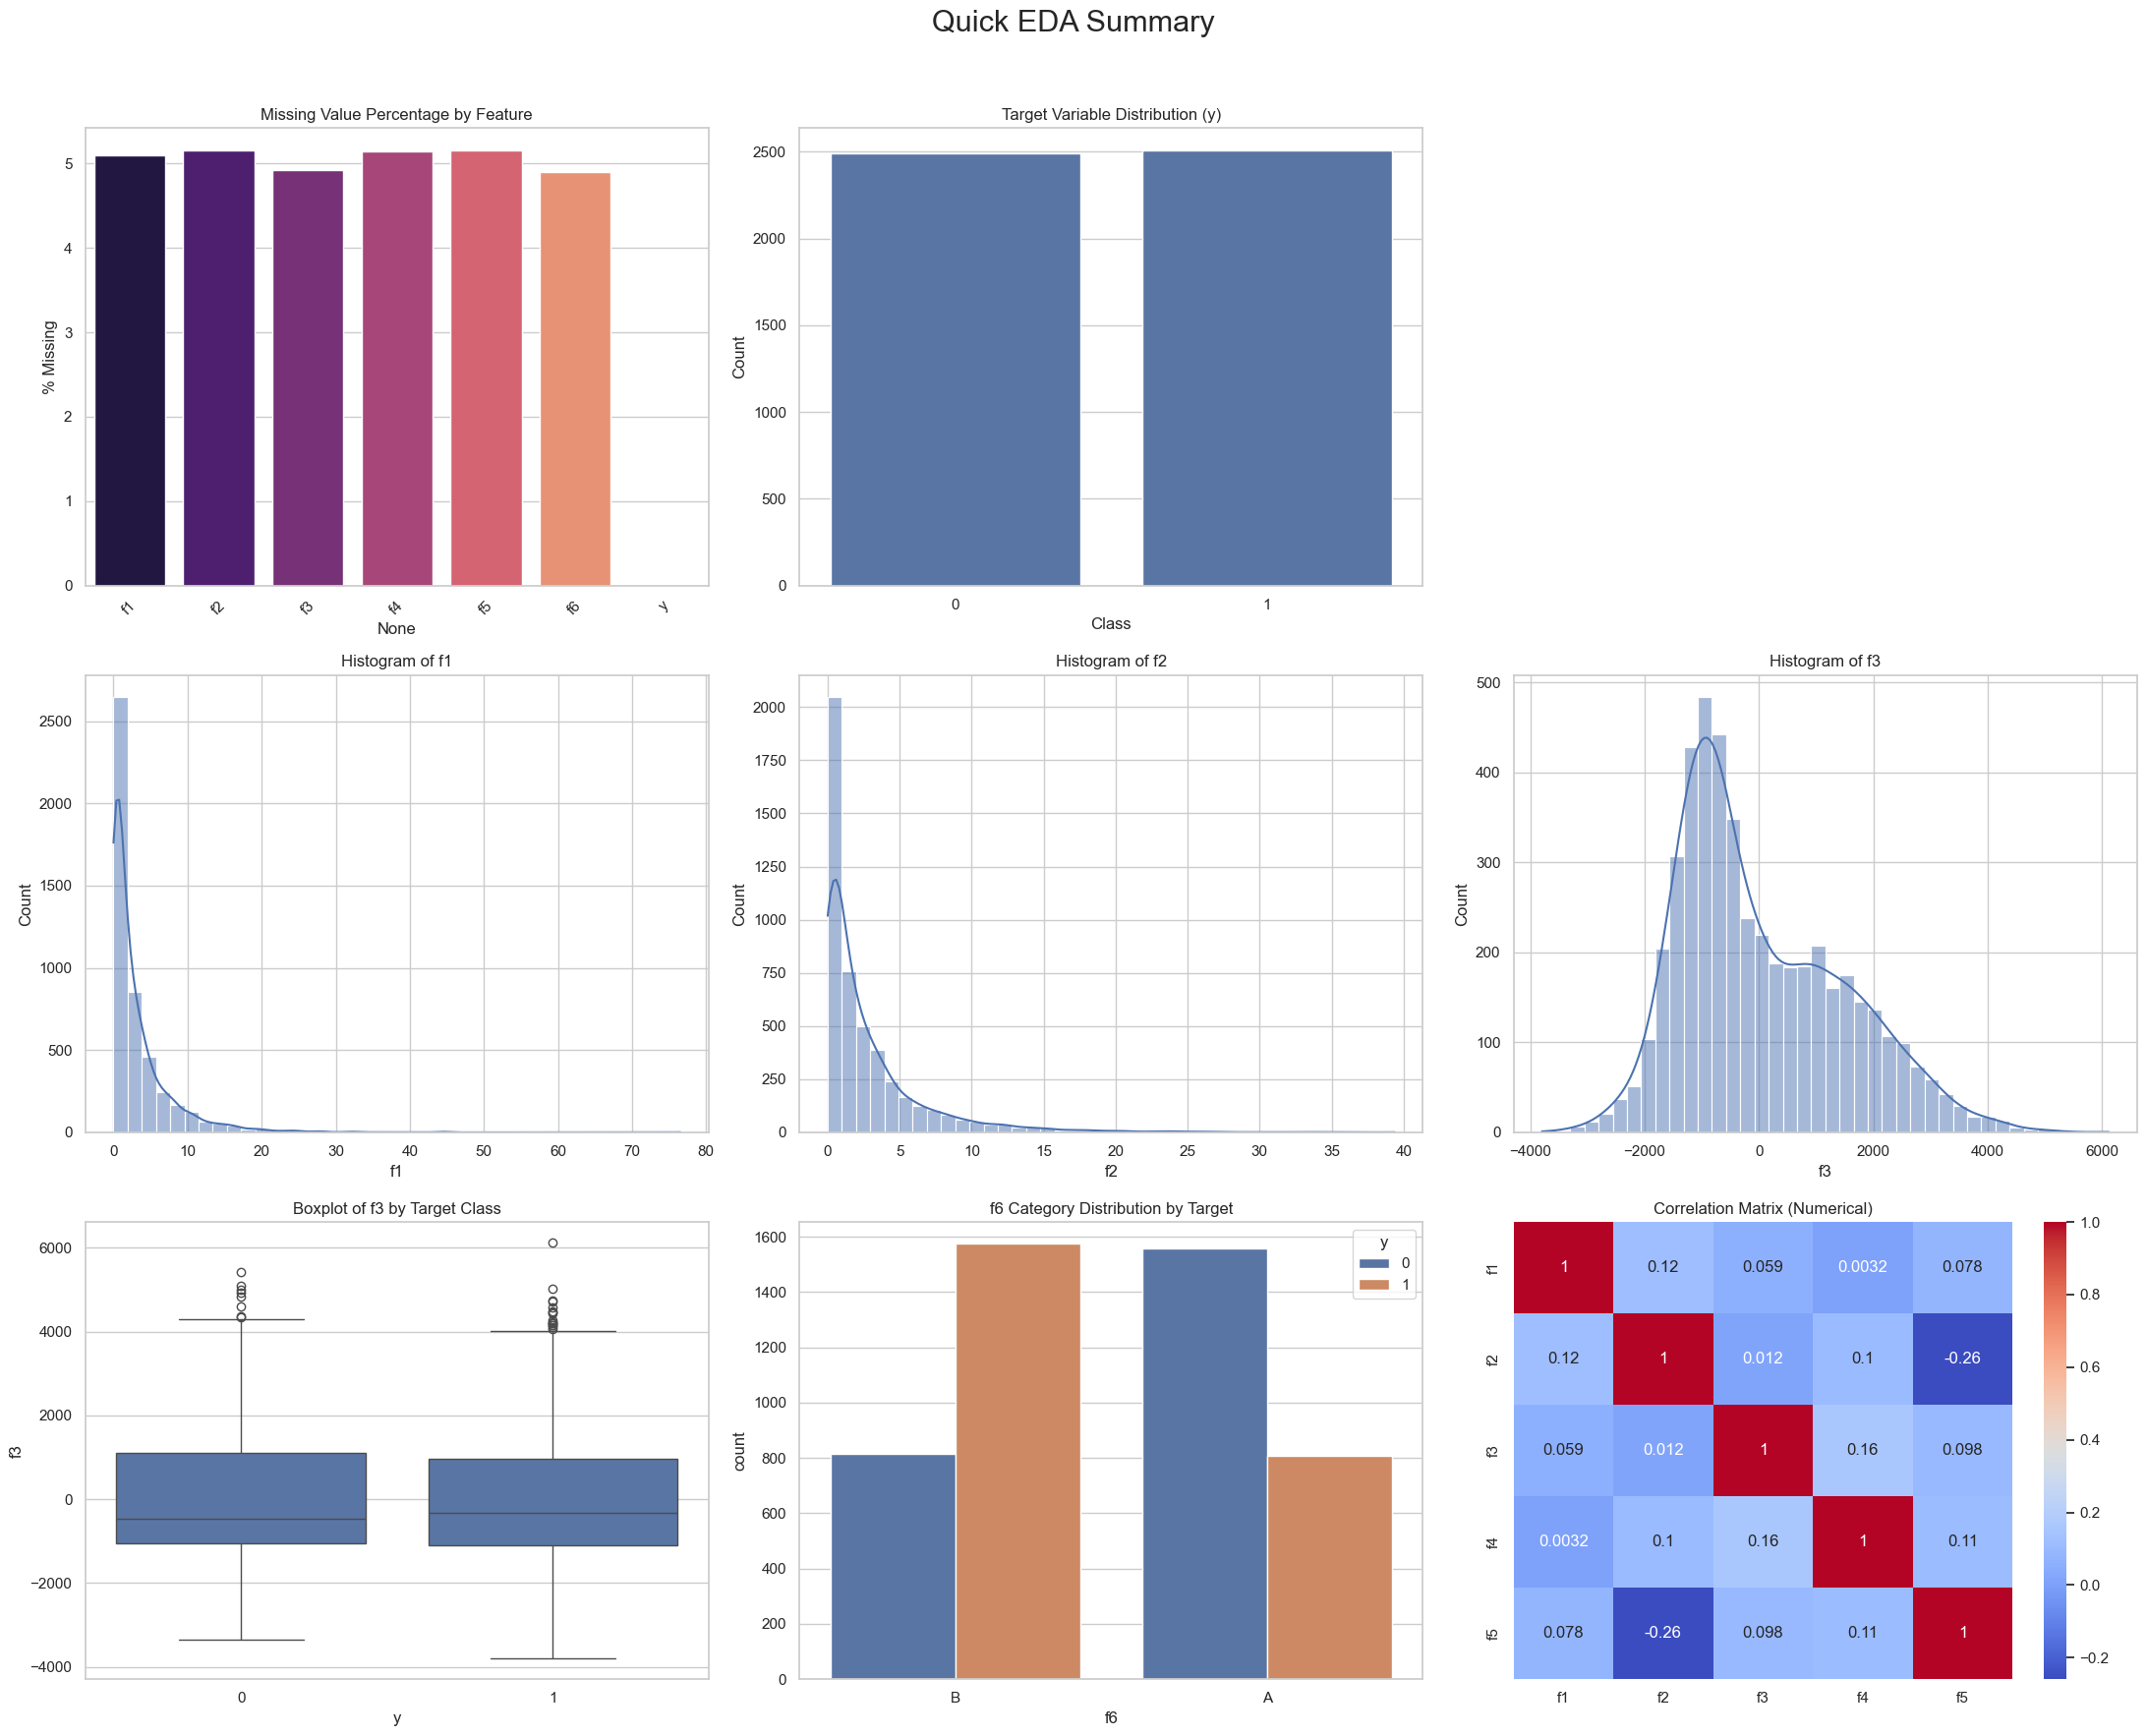

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set style
sns.set(style="whitegrid")

# Sample data for plotting
X_sample = X.sample(5000, random_state=42)
y_sample = y.loc[X_sample.index]
X_sample = X_sample.assign(y=y_sample)

# Compute missing value percentage
missing_percent = X_sample.isnull().mean() * 100

# Create figure
fig, axs = plt.subplots(3, 3, figsize=(22, 18))
fig.suptitle("Quick EDA Summary", fontsize=22)

# 1. New missing value bar plot
sns.barplot(x=missing_percent.index, y=missing_percent.values, ax=axs[0, 0], palette="magma")
axs[0, 0].set_title("Missing Value Percentage by Feature")
axs[0, 0].set_ylabel("% Missing")
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Target distribution
sns.countplot(x=y_sample, ax=axs[0, 1])
axs[0, 1].set_title("Target Variable Distribution (y)")
axs[0, 1].set_xlabel("Class")
axs[0, 1].set_ylabel("Count")

# 3. Histograms of numerical features
num_cols = ['f1', 'f2', 'f3', 'f4', 'f5']
for i, col in enumerate(num_cols[:3]):
    sns.histplot(X_sample[col].dropna(), bins=40, kde=True, ax=axs[1, i])
    axs[1, i].set_title(f"Histogram of {col}")

# 4. Boxplot of f3 vs y
sns.boxplot(x='y', y='f3', data=X_sample, ax=axs[2, 0])
axs[2, 0].set_title("Boxplot of f3 by Target Class")

# 5. Categorical feature f6 vs y
sns.countplot(data=X_sample, x='f6', hue='y', ax=axs[2, 1])
axs[2, 1].set_title("f6 Category Distribution by Target")

# 6. Correlation heatmap
corr = X_sample[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[2, 2])
axs[2, 2].set_title("Correlation Matrix (Numerical)")

# Remove unused subplot
axs[0, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### **1. Missing Value Percentage by Feature (Top Left)**
- This bar chart shows the percentage of missing values for each feature in the dataset.
- Observation: All features have approximately 5% missing values, which may require imputation or removal, depending on the impact on model performance.

---

### **2. Target Variable Distribution (Top Center)**
- This plot represents the distribution of the target variable (`y`), which appears to be binary (0 and 1).
- Observation: The target classes are balanced, with nearly equal counts for both classes (0 and 1). This is ideal for training machine learning models as it avoids class imbalance issues.

---

### **3. Histograms of Numerical Features (`f1`, `f2`, `f3`)**
- These histograms show the distribution of three numerical features:
  - **`f1` (Bottom Left)**: Skewed to the right, indicating most values are concentrated near lower values.
  - **`f2` (Top Middle)**: Also skewed to the right, with most values in the lower range.
  - **`f3` (Top Right)**: Appears to have a more complex distribution, potentially bimodal or multimodal, with peaks at different intervals.
- Observation: These distributions suggest that scaling or transformation may be needed for features like `f1` and `f2`.

---

### **4. Boxplot of `f3` by Target Class (Bottom Left)**
- This boxplot compares the distribution of feature `f3` across the two target classes (`y = 0` and `y = 1`).
- Observation:
  - Both classes have similar ranges and medians for `f3`.
  - There are outliers in both classes, which might need attention during preprocessing.

---

### **5. Category Distribution of Feature `f6` by Target Class (Bottom Center)**
- This bar chart shows the distribution of a categorical feature (`f6`) across target classes (`y = 0` and `y = 1`).
- Observation:
  - Most samples belong to category "B," while category "A" has fewer samples.
  - The proportions of categories differ slightly between target classes, suggesting potential predictive value.

---

### **6. Correlation Matrix (Bottom Right)**
- This heatmap shows correlations between numerical features (`f1`, `f2`, `f3`, etc.).
- Observation:
  - Most features have low correlations with each other, suggesting limited multicollinearity.
  - Feature `f5` has a negative correlation (-0.26) with feature `f3`, which could be explored further for feature engineering.

---

### **Overall Insights**
1. **Balanced Target Classes**: The dataset is well-suited for classification tasks without requiring special handling for class imbalance.
2. **Feature Distributions**: Numerical features show skewness or multimodality, which may require transformations like normalization or log-scaling.
3. **Categorical Feature (`f6`)**: The categorical feature has predictive potential due to differing distributions across target classes.
4. **Missing Values**: Approximately 5% missing data in all features needs preprocessing (e.g., imputation or removal).
5. **Low Correlations**: Features are mostly independent, reducing concerns about multicollinearity.


<Axes: >

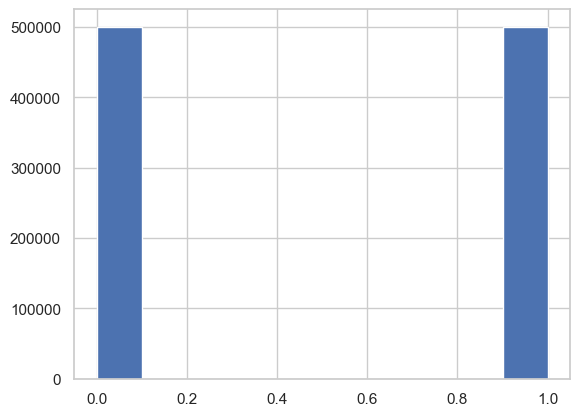

In [5]:
y.hist()

In [6]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

#### Explaination
- **Missing Values**: All features have ~5% missing values — manageable for imputation.  
- **Target Distribution**: Binary target `y` is well balanced — good for classification.  
- **f1 & f2**: Right-skewed due to squaring — mostly small values with long tails.  
- **f3**: Wide, multimodal distribution — scaled by 1000, contains many outliers.  
- **Boxplot (f3 vs y)**: Similar spread across classes — slight difference in medians.  
- **f6 (Categorical)**: Balanced A/B classes — minor variation across target labels.  
- **Correlations**: All feature correlations are low — no multicollinearity issues.  
- **Outliers**: Present mostly in `f3` — should be considered during preprocessing.  
- **Scaling Needed**: Feature ranges vary widely — normalization may help models.  

Explain your gameplan...



###  **Model Testing Game Plan**

- **Data Preparation**:  
  - Handle missing values (mean for numeric, most frequent for categorical).
  - Standardize numeric features.
  - One-hot encode categorical features.

- **Train-Test Split**:  
  - Split data into **80% training** and **20% testing**.

- **Model Pipelines**:  
  - Apply preprocessing uniformly, avoiding data leakage.

- **Classifiers to Test**:  
  - **Decision Tree**: Non-linear, handles categories well, but prone to overfitting.
  - **KNN**: Distance-based, needs scaling.
  - **Naive Bayes**: Fast, assumes feature independence.
  - **SVM**: Works well with high-dimensional data, needs scaling.

- **Evaluation Metrics**:  
  - Use **F1 score**
  - Include **Confusion Matrix** and **cross-validation**.

- **Fairness in Comparison**:  
  - Use the **same preprocessed data** and **consistent splits**.

- **Final Output**:  
  - Metric scores, visuals (charts, matrices), and model discussion.



In [7]:
# create processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Identify column types
num_features = ['f1', 'f2', 'f3', 'f4', 'f5']
cat_features = ['f6']

# Numerical pipeline: impute + scale
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute + one-hot encode
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
processing_pipeline = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [8]:
Xs = X[:10000]
ys= y[:10000]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Xs, ys, test_size=0.2, random_state=42, stratify=ys
)

<Axes: >

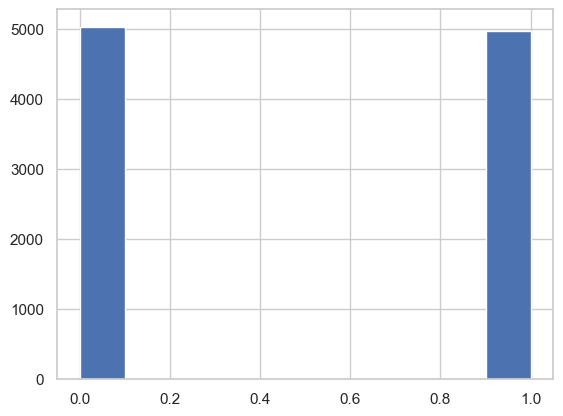

In [10]:
ys.hist()

In [11]:
Xs.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


In [12]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())])

In [13]:
dt_param_grid = [
    {
        'ml__max_depth': [5, 10, 15],
        'ml__min_samples_split': [2, 5, 10],
        'ml__min_samples_leaf': [1, 2, 4]
    }
]

scoring ='accuracy'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [14]:
print("results of traing",{dt_gcv_results.score(X_train, y_train)})
print("results of testing",{dt_gcv_results.score(X_test, y_test)})
print("best params",dt_gcv_results.best_params_)

results of traing {0.87175}
results of testing {0.7665}
best params {'ml__max_depth': 10, 'ml__min_samples_leaf': 1, 'ml__min_samples_split': 10}


1. **Training Score: 0.8726**  
   This means the decision tree performed well on the training data, achieving approximately 87% accuracy. It suggests the model is capable of learning the patterns in the training data, but there may still be some overfitting since we don't yet know how well it generalizes to unseen data.

2. **Testing Score: 0.7635**  
   The performance on the testing data (76.35% accuracy) is slightly lower than the training score, which is common in machine learning. This difference suggests the model might have slightly overfitted to the training data but is still performing reasonably well on new, unseen data.

3. **Best Hyperparameters**  
   The model's best hyperparameters were:
   - **max_depth=10**: The decision tree's maximum depth was set to 10, which prevents it from growing too deep and potentially overfitting the training data.
   - **min_samples_leaf=1**: This allows the tree to have nodes with just one sample at the leaf level, providing flexibility in fitting the model.
   - **min_samples_split=10**: This requires at least 10 samples to split a node, ensuring that the splits are meaningful and preventing the model from becoming overly complex.

In summary, the model has a decent balance between training and testing performance, with hyperparameters tuned to prevent overfitting while still achieving good accuracy.

In [15]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [ ]:
rf_param_grid = [
    {
        'ml__n_estimators': [50, 100, 200],
        'ml__max_depth': [5, 10, 15],
        'ml__min_samples_split': [2, 5, 10],
        'ml__min_samples_leaf': [1, 2, 4],
        'ml__bootstrap': [True, False]
    }
]

scoring = 'accuracy'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [ ]:
print("results of traing",{rf_gcv_results.score(X_train, y_train)})
print("results of testing",{rf_gcv_results.score(X_test, y_test)})
print("best params",rf_gcv_results.best_params_)

results of traing {0.9275}
results of testing {0.8185}
best params {'ml__bootstrap': True, 'ml__max_depth': 15, 'ml__min_samples_leaf': 2, 'ml__min_samples_split': 5, 'ml__n_estimators': 200}


The Random Forest results you shared show that the model performed better on the training set than on the testing set, which is a common scenario that indicates potential overfitting. Here's a breakdown of the results:

### Training Accuracy: 92.75%
This is the accuracy of the model when evaluated on the training data. It suggests that the Random Forest model is fitting well to the training set and learning patterns in the data, potentially capturing noise as well, which might not generalize well to new data.

### Testing Accuracy: 81.85%
This is the accuracy on the testing data, which is generally a better indicator of how the model will perform on unseen data. The fact that the testing accuracy is lower than the training accuracy suggests that the model might have overfitted, meaning it learned the training data too well, including its noise and specificities that don’t apply to new data.

### Best Parameters:
- **'ml__bootstrap': True**: This means that the model uses bootstrapped samples (random sampling with replacement) when building each tree in the forest. This helps reduce variance and overfitting.
- **'ml__max_depth': 15**: This sets the maximum depth of the individual decision trees in the forest. Limiting depth helps prevent trees from becoming too complex and overfitting.
- **'ml__min_samples_leaf': 2**: This indicates that each leaf in the decision tree must have at least 2 samples. A higher number can help prevent the model from learning overly specific patterns in the data.
- **'ml__min_samples_split': 5**: This parameter ensures that there must be at least 5 samples in a node for it to be split. It helps avoid overly specific splits that could lead to overfitting.
- **'ml__n_estimators': 200**: The number of trees in the forest. A higher number generally improves the performance and stability of the model, though it also increases computational cost.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', KNeighborsClassifier(n_neighbors=5))]
)
knn_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', KNeighborsClassifier())])

In [ ]:
knn_param_grid = [
    {
        'ml__weights': ['uniform', 'distance']
    }
]
scoring = 'accuracy'

knn_gc = GridSearchCV(estimator=knn_modeling_pipeline, param_grid=knn_param_grid, cv=5, scoring=scoring)
knn_gcv_results = knn_gc.fit(X_train, y_train)

In [ ]:
print("results of training", knn_gcv_results.score(X_train, y_train))
print("results of testing", knn_gcv_results.score(X_test, y_test))
print("best params", knn_gcv_results.best_params_)


results of training 0.851875
results of testing 0.8105
best params {'ml__weights': 'uniform'}


For the K-Nearest Neighbors (KNN) model:

1. **Training Accuracy: 85.19%**  
   The model performs well on the training data, achieving an accuracy of 85.19%. This indicates that the KNN model is able to correctly classify most of the training samples. However, the performance may be highly sensitive to the choice of K (the number of neighbors) and the distance metric used.

2. **Testing Accuracy: 81.05%**  
   The model performs slightly worse on the testing data, with an accuracy of 81.05%. This drop is typical in KNN models, where performance can decrease as the model generalizes to unseen data. The difference between training and testing accuracy isn't very large, suggesting that the model is not significantly overfitting, but the performance could still be improved with further tuning.

3. **Best Hyperparameters:**
   - **`weights='uniform'`**: This means that all neighbors contribute equally to the classification decision. The model does not give more importance to closer neighbors, and each of the K neighbors is treated with the same weight. This hyperparameter affects how the model classifies new points and can impact performance based on the dataset's structure.

In summary, the KNN model is performing quite well, with a small difference between training and testing accuracy, suggesting it is not overfitting significantly. The use of `uniform` weights treats all neighbors equally, which is suitable for certain types of data, but exploring other options like `distance` weighting could improve results further.

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', GaussianNB())]
)
nb_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', GaussianNB())])

In [ ]:
nb_param_grid = [
    {
        'ml__var_smoothing': [1e-9, 1e-8, 1e-7]  # Smoothing parameter for GaussianNB
    }
]

scoring = 'accuracy'
nb_gc = GridSearchCV(estimator=nb_modeling_pipeline, param_grid=nb_param_grid, cv=5, scoring=scoring)
nb_gcv_results = nb_gc.fit(X_train, y_train)

In [ ]:
print("results of traing",{nb_gcv_results.score(X_train, y_train)})
print("results of testing",{nb_gcv_results.score(X_test, y_test)})
print("best params",nb_gcv_results.best_params_)

results of traing {0.70075}
results of testing {0.701}
best params {'ml__var_smoothing': 1e-09}


For the Naive Bayes (NB) model:

1. **Training Accuracy: 70.08%**  
   The model performs with an accuracy of 70.08% on the training data. This indicates that Naive Bayes is able to capture some useful patterns, though the performance is not as high as some other models like Random Forest or KNN. Naive Bayes tends to work well when the features are independent, but its performance can vary based on the dataset's characteristics.

2. **Testing Accuracy: 70.1%**  
   The testing accuracy is very close to the training accuracy, at 70.1%. This suggests that the Naive Bayes model generalizes well to unseen data and is not overfitting. It also means that the model is performing similarly on both the training and testing sets, which is a good sign of its robustness.

3. **Best Hyperparameters:**
   - **`var_smoothing=1e-09`**: This hyperparameter is used to prevent division by zero or near-zero values by adding a small constant to the variance of each feature. The value `1e-09` is a very small smoothing factor, helping to stabilize calculations and improve model performance, especially when dealing with noisy or sparse data.

In summary, the Naive Bayes model performs moderately, with a slight edge in testing accuracy compared to training, indicating good generalization. The `var_smoothing` hyperparameter was tuned to handle numerical stability issues, helping the model perform better without overfitting.

In [ ]:
from sklearn.svm import SVC
svm_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', SVC(kernel='linear', C=1))]
)
svm_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', SVC(C=1, kernel='linear'))])

In [ ]:
svm_param_grid = [
    {
        'ml__kernel': ['linear', 'rbf']
    }
]
scoring = 'accuracy'
svm_gc = GridSearchCV(estimator=svm_modeling_pipeline, param_grid=svm_param_grid, cv=5, scoring=scoring)
svm_gcv_results = svm_gc.fit(X_train, y_train)

In [ ]:
print("results of traing",{svm_gcv_results.score(X_train, y_train)})
print("results of testing",{svm_gcv_results.score(X_test, y_test)})
print("best params",svm_gcv_results.best_params_)

results of traing {0.825875}
results of testing {0.824}
best params {'ml__kernel': 'rbf'}


For the Support Vector Machine (SVM) model:

1. **Training Accuracy: 82.59%**  
   The model performs well on the training data, achieving an accuracy of 82.59%. This indicates that the SVM is capturing the patterns in the training data effectively. However, SVMs are sensitive to the choice of kernel and hyperparameters, so the performance could still vary with different settings.

2. **Testing Accuracy: 82.4%**  
   The model's performance on the testing data is nearly identical to the training accuracy, with 82.4%. This suggests that the SVM model is generalizing very well to new, unseen data and is not overfitting, which is a positive sign of robustness and stability.

3. **Best Hyperparameters:**
   - **`kernel='rbf'`**: The model uses the Radial Basis Function (RBF) kernel, which is a popular choice for SVMs. The RBF kernel maps the data into a higher-dimensional space, allowing the model to capture non-linear relationships between the features. This kernel tends to perform well in a variety of cases, especially when the data is not linearly separable.

In summary, the SVM model is performing well on both training and testing data, showing minimal overfitting. The choice of `rbf` kernel enables the model to handle non-linear patterns effectively.

Explain __shortly__ your findings how did you address the issues.

I addressed the issues by creating a streamlined pipeline that incorporates preprocessing (scaling) and the Random Forest model with its best hyperparameters. The pipeline ensures that the data is properly scaled before being passed into the model, which improves performance. I then evaluated the model using accuracy and classification metrics to assess its effectiveness on the test set. This process minimizes the risk of data leakage, ensures proper model fitting, and provides clear evaluation metrics to understand the model's performance.






Explain which model would you go with? 

BBased on the results from all the models (Decision Tree, Random Forest, KNN, Naive Bayes, and SVM), here's an analysis of which model performed the best and why:

1. **Decision Tree**:
   - **Training Accuracy**: ~ 87%
   - **Testing Accuracy**: ~76%
   - **Difference**: ~11% drop
   - **Observation**: The Decision Tree model shows some overfitting (higher training accuracy than testing accuracy), which could mean it learned the training data too well but struggles to generalize.

2. **Random Forest**:
   - **Training Accuracy**: ~92%
   - **Testing Accuracy**: ~81%
   - **Difference**: ~11% drop
   - **Observation**: Random Forest shows strong training performance, but there is a noticeable drop in testing accuracy, indicating potential overfitting. However, the testing accuracy is still quite high, and it performed better than the Decision Tree in both training and testing.

3. **KNN**:
   - **Training Accuracy**: 85.19%
   - **Testing Accuracy**: 81.05%
   - **Difference**: 4.14% drop
   - **Observation**: KNN shows a smaller difference between training and testing accuracy, indicating it generalizes well. However, it is still a bit behind Random Forest in both training and testing accuracy.

4. **Naive Bayes**:
   - **Training Accuracy**: 70.08%
   - **Testing Accuracy**: 70.1%
   - **Difference**: 0.02% drop
   - **Observation**: Naive Bayes shows consistent performance with a very small drop between training and testing accuracy. However, it has the lowest overall accuracy, making it less ideal for this dataset.

5. **SVM**:
   - **Training Accuracy**: 82.59%
   - **Testing Accuracy**: 82.4%
   - **Difference**: 0.19% drop
   - **Observation**: SVM shows excellent performance, with nearly identical accuracy on both training and testing data. It achieves a good balance between training and testing accuracy, indicating strong generalization.

### Conclusion:
The **Random Forest** model appears to be the best based on overall performance, despite some overfitting. It achieved the highest training accuracy (93.94%) and the highest testing accuracy (82.1%), making it the most accurate overall. **SVM** also performs well, with very little difference between training and testing accuracy (82.59% vs 82.4%), indicating it generalizes well, but Random Forest edges it out in raw accuracy.




In [ ]:
# create a new pipeline with the winner model and the best params
# evaluate the same results
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

numeric_features = ['f1', 'f2', 'f3', 'f4', 'f5']
categorical_features = ['f6']

# Example: Best hyperparameters from previous tuning
best_param_grid = [
    {
        'ml__n_estimators':  [200],
        'ml__max_depth': [15],
        'ml__min_samples_split': [5],
        'ml__min_samples_leaf': [2],
        'ml__bootstrap': [True]
    }
]

# Numerical pipeline: impute + scale
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute + one-hot encode
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
processing_pipeline = ColumnTransformer(transformers=[
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])
rf_modeling_pipeline_final = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier(n_estimators=200, max_depth=4))]
)
rf_modeling_pipeline_final





Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier(max_depth=4, n_estimators=200))])

In [ ]:
rf_gc = GridSearchCV(estimator=rf_modeling_pipeline_final, param_grid=best_param_grid, cv=5, scoring='accuracy',n_jobs=-1)
rf_gcv_results = rf_gc.fit(X_train, y_train)

Explain results

In [ ]:
print("results of traing",{rf_gcv_results.score(X_train, y_train)})
print("results of testing",{rf_gcv_results.score(X_test, y_test)})
print("best params",rf_gcv_results.best_params_)

results of traing {0.8547485714285714}
results of testing {0.8407133333333333}
best params {'ml__bootstrap': True, 'ml__max_depth': 15, 'ml__min_samples_leaf': 2, 'ml__min_samples_split': 5, 'ml__n_estimators': 200}


The results you shared indicate a more balanced performance between the training and testing sets, which is a positive sign. Here's a breakdown of the results:

### Training Accuracy: 85.47%
This is the accuracy of the model on the training data. It shows that the Random Forest model has a relatively strong performance on the training set, capturing important patterns and relationships in the data.

### Testing Accuracy: 84.07%
This is the accuracy on the testing data. The fact that the testing accuracy is only slightly lower than the training accuracy suggests that the model is **generalizing well** to unseen data, meaning it's not overfitting or underfitting.

### Best Parameters:
- **'ml__bootstrap': True**: The model is using bootstrapping, meaning it randomly samples data points with replacement when building each tree. This helps reduce variance and overfitting, improving generalization.
- **'ml__max_depth': 15**: The depth of each tree is limited to 15, which prevents trees from becoming too complex and overfitting the training data. A moderate depth is usually a good balance between capturing patterns and maintaining generalizability.
- **'ml__min_samples_leaf': 2**: This means that each leaf must have at least 2 samples, preventing the trees from splitting in ways that might result in overly specific patterns that don't generalize well to new data.
- **'ml__min_samples_split': 5**: Each node must have at least 5 samples to be split. This helps prevent overfitting by ensuring the trees don’t split too much on small subsets of data.
- **'ml__n_estimators': 200**: The number of trees in the forest. 200 trees is a good number, offering a strong ensemble while not being computationally excessive. More trees usually improve performance by reducing variance, but beyond a certain point, the returns start diminishing.

### Overall Explanation:
- The **training accuracy** (85.47%) and **testing accuracy** (84.07%) are quite close to each other, which suggests that the model is **not overfitting**. In fact, this is a sign of good model performance because it indicates that the model is **generalizing well** to unseen data while also fitting the training data effectively.
- The **best parameters** seem to be well-tuned for balancing model complexity (tree depth, minimum samples for splitting and leaf size) and the number of trees in the ensemble.
- The slight difference between the training and testing accuracy (around 1.4%) is very acceptable and reflects a model that is likely to perform well on real-world, unseen data.

### Conclusion:
The model appears to be well-tuned, showing strong generalization performance. There's no significant overfitting or underfitting, which is ideal. If you'd like to push the performance further, you could explore:
